In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import os 
import keras 
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import clear_output as cls

# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Model Creation
from keras.models import Sequential, load_model
from keras.layers import Dense
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
train_data = '/content/drive/MyDrive/Monkey/MonkeySpeciesData/TrainingData'
test_data = '/content/drive/MyDrive/Monkey/MonkeySpeciesData/PredictionData'

In [5]:
class_list = sorted(os.listdir(train_data))
class_len = len(class_list)

In [6]:
class_list

['Bald Uakari',
 'Emperor Tamarin',
 'Golden Monkey',
 'Gray Langur',
 'Hamadryas Baboon',
 'Mandril',
 'Proboscis Monkey',
 'Red Howler',
 'Vervet Monkey',
 'White Faced Saki']

In [16]:
# Initialize Generator
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True, validation_split=0.2)

test_gen = ImageDataGenerator(rescale=1./255)

# Load Data
BATCH_SIZE = 32
train_set = train_gen.flow_from_directory(train_data,
                                          subset='training',
                                          target_size=(256,256),
                                          shuffle=True,
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE)
valid_set = train_gen.flow_from_directory(train_data, 
                                          subset='validation',
                                          target_size=(256,256),
                                          shuffle=True,
                                          class_mode='binary',
                                          batch_size=BATCH_SIZE)
test_set = test_gen.flow_from_directory(test_data,
                                        target_size=(256,256),
                                        shuffle=True,
                                        class_mode='binary',
                                        batch_size=BATCH_SIZE)

Found 8008 images belonging to 10 classes.
Found 2001 images belonging to 10 classes.
Found 1306 images belonging to 10 classes.


In [14]:
# Model URL
url = "https://tfhub.dev/google/bit/m-r50x1/1"

# Load From HUB
inputLayers = hub.KerasLayer(url)

In [15]:
# Creating a Model
model_name = "MonkeyClassification"
outputLayer = Dense(class_len,
                    activation='softmax',
                    kernel_initializer='zeros')
model = Sequential([inputLayers, outputLayer],
                   name=model_name)

In [17]:
# Configure Learning rate Scheduler and Optimizer
learning_rate = 1e-3
SCHEDULE_BOUNDARIES = [300, 400, 500]
schedule_lr = PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                      values=[learning_rate, learning_rate*0.1, learning_rate*0.01, learning_rate*0.001])
optimizer = SGD(learning_rate=schedule_lr, momentum=0.8)

In [18]:
# Compiling the Model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="Top3Acc")
    ]
)

In [22]:
call_backs = [EarlyStopping(patience=3, restore_best_weights=True),ModelCheckpoint(model_name + ".h5", save_best_only=True)]

In [26]:
# Training the Model
trained_model = model.fit(train_set, validation_data=valid_set, epochs=5, callbacks=call_backs)
model.save(model_name + '.h5')

Epoch 1/5
251/251 [==============================] - 1231s 5s/step - loss: 0.2000 - Accuracy: 0.9488 - Top3Acc: 0.9869 - val_loss: 0.2505 - val_Accuracy: 0.9365 - val_Top3Acc: 0.9770
Epoch 2/5
251/251 [==============================] - 170s 676ms/step - loss: 0.1475 - Accuracy: 0.9624 - Top3Acc: 0.9906 - val_loss: 0.2524 - val_Accuracy: 0.9375 - val_Top3Acc: 0.9760
Epoch 3/5
251/251 [==============================] - 172s 682ms/step - loss: 0.1510 - Accuracy: 0.9608 - Top3Acc: 0.9913 - val_loss: 0.2513 - val_Accuracy: 0.9375 - val_Top3Acc: 0.9780
Epoch 4/5
251/251 [==============================] - 172s 686ms/step - loss: 0.1451 - Accuracy: 0.9629 - Top3Acc: 0.9915 - val_loss: 0.2475 - val_Accuracy: 0.9420 - val_Top3Acc: 0.9790
Epoch 5/5
251/251 [==============================] - 169s 674ms/step - loss: 0.1493 - Accuracy: 0.9613 - Top3Acc: 0.9914 - val_loss: 0.2528 - val_Accuracy: 0.9385 - val_Top3Acc: 0.9800


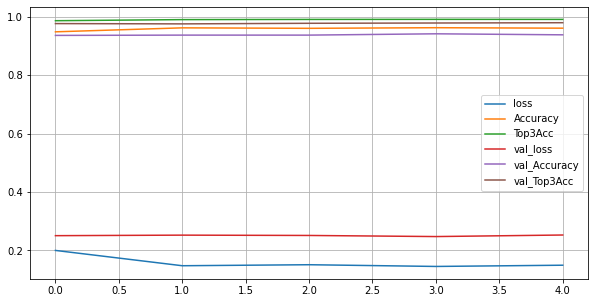

In [36]:
pd.DataFrame(trained_model.history).plot(figsize=(10,5))
plt.grid()
plt.show()

In [37]:
prediction = model.predict(test_set)
prediction = np.argmax(prediction, axis=1)

41/41 [==============================] - 280s 7s/step


In [39]:
prediction

array([7, 3, 1, ..., 8, 8, 4])

1/1 [==============================] - 0s 34ms/step


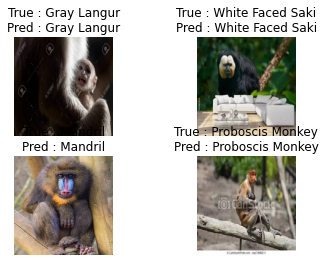

In [90]:
i = 1
for images, labels in iter(test_set):
  # Select Random Data
        
  id = np.random.randint(len(images))
  image_m, label = tf.expand_dims(images[id], axis=0), class_list[int(labels[id])]
        
  # Make Prediction
  pred = class_list[np.argmax(model.predict(image_m))]
  title = f"True : {label}\nPred : {pred}"
  plt.subplot(2, 2, i)
  plt.imshow(image_m[0])
  plt.axis('off')
  plt.title(title)
  
  i+=1
  if i>4:
    break
  cls()

In [88]:
img = image.load_img('/content/drive/MyDrive/Monkey/MonkeySpeciesData/PredictionData/White Faced Saki/WFS (1004).jpeg', target_size = (256,256))
x=image.img_to_array(img)
x=x/255
x=tf.expand_dims(x,axis=0)
a=np.argmax(model.predict(x))
class_list[a]

1/1 [==============================] - 0s 28ms/step


'White Faced Saki'